In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_dir = './dataset/train'
test_dir = './dataset/test'
val_dir = './dataset/val'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True
                              )
test_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True
                             )
val_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True
                            )

train = train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test = test_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

val = val_gen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 18322 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Found 2625 images belonging to 10 classes.


In [17]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.models import load_model


inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception.trainable = False

tmp = GlobalAveragePooling2D()(inception.output)
tmp = Flatten()(tmp)
tmp = Dense(128, activation='relu')(tmp)
tmp = Dense(64, activation='relu')(tmp)
output_layer = Dense(10, activation='softmax')(tmp)

model = tf.keras.Model(inputs=inception.input, outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_201 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 127, 127, 32  96         ['conv2d_201[0][0]']             
 Normalization)                 )                                                           

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

In [19]:
history = model.fit(train,
                    steps_per_epoch=train.samples/train.batch_size,
                    epochs=10,
                    validation_data=val,
                    validation_steps=val.samples/val.batch_size,
                   callbacks=[early_stopping_callback]) 

Epoch 1/10
572/572 [==============================] - 53s 86ms/step - loss: 0.4251 - accuracy: 0.8704 - val_loss: 0.3788 - val_accuracy: 0.8800
Epoch 2/10
572/572 [==============================] - 51s 88ms/step - loss: 0.3024 - accuracy: 0.9036 - val_loss: 0.3024 - val_accuracy: 0.9074
Epoch 3/10
572/572 [==============================] - 53s 93ms/step - loss: 0.2571 - accuracy: 0.9173 - val_loss: 0.2707 - val_accuracy: 0.9154
Epoch 4/10
572/572 [==============================] - 54s 95ms/step - loss: 0.2362 - accuracy: 0.9211 - val_loss: 0.2903 - val_accuracy: 0.9082
Epoch 5/10
572/572 [==============================] - 55s 96ms/step - loss: 0.2146 - accuracy: 0.9274 - val_loss: 0.2990 - val_accuracy: 0.9048
Epoch 6/10
572/572 [==============================] - 55s 96ms/step - loss: 0.2144 - accuracy: 0.9294 - val_loss: 0.2628 - val_accuracy: 0.9150
Epoch 7/10
572/572 [==============================] - 55s 97ms/step - loss: 0.1944 - accuracy: 0.9347 - val_loss: 0.2711 - val_accuracy:

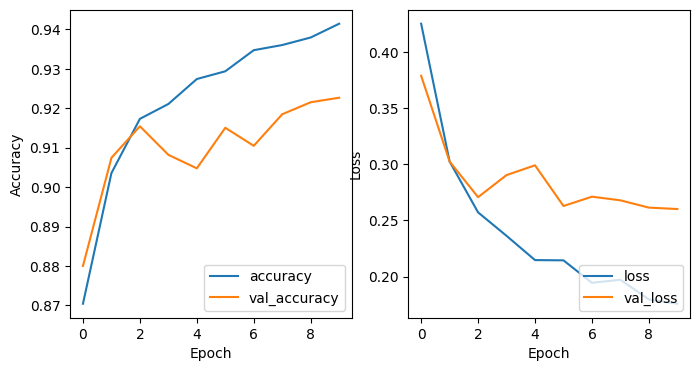

In [22]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [23]:
model.save('Animals.keras')

In [24]:
test_loss, test_acc = model.evaluate(test, verbose=2)
print(f'Accuracy : {test_acc * 100} %')

164/164 - 12s - loss: 0.2610 - accuracy: 0.9207 - 12s/epoch - 71ms/step
Accuracy : 92.06804633140564 %


In [25]:
from sklearn.metrics import classification_report

predictions = model.predict(test)
predicted_labels = tf.argmax(predictions, axis=1)

# Afficher le rapport de classification
print(classification_report(test.classes, predicted_labels, target_names=train.class_indices))

164/164 [==============================] - 13s 76ms/step
              precision    recall  f1-score   support

        cane       0.91      0.92      0.91       972
    elefante       0.90      0.95      0.93       289
    farfalla       0.95      0.98      0.96       422
     gallina       0.97      0.93      0.95       619
       gatto       0.97      0.82      0.89       333
       horse       0.87      0.92      0.89       524
       mucca       0.85      0.83      0.84       373
       ragno       0.99      0.98      0.99       964
       sheep       0.88      0.87      0.88       364
    squirrel       0.88      0.97      0.92       372

    accuracy                           0.92      5232
   macro avg       0.92      0.92      0.92      5232
weighted avg       0.93      0.92      0.92      5232



Matrice de confusion non normalisée


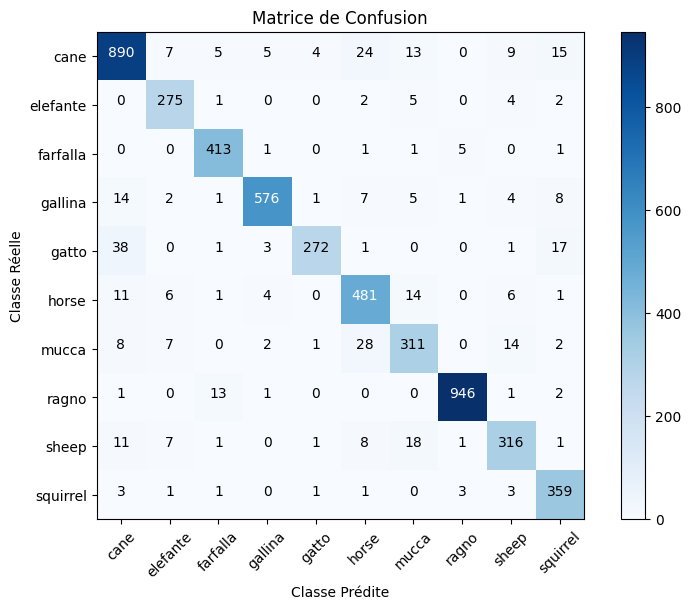

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(test.classes, predicted_labels)

# Définition de la fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, classes, normalize=False, title='Matrice de Confusion', cmap=plt.cm.Blues):
    """
    Affiche une matrice de confusion.
    :param cm: Matrice de confusion.
    :param classes: Liste des noms de classes.
    :param normalize: Si True, normalise la matrice de confusion.
    :param title: Titre du graphique.
    :param cmap: Color map utilisée.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Réelle')
    plt.xlabel('Classe Prédite')

# Définir les noms des catégories
class_names = train.class_indices

# Afficher la matrice de confusion avec les noms des catégories
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False)
plt.show()